In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers.normalization import BatchNormalization

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

C:\Users\Muhammad Yahya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Muhammad Yahya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Muhammad Yahya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Muhammad Yahya\Anaconda3\lib\site-packages\tensorflow\python\framework

In [2]:
def silu(x):
    return x * tf.keras.activations.tanh(tf.keras.activations.softplus(x))

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=16, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
image_size = 128
train_path = r"C:\Users\Muhammad Yahya\Desktop\stage1_train"
epochs = 35
batch_size = 16

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 30

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


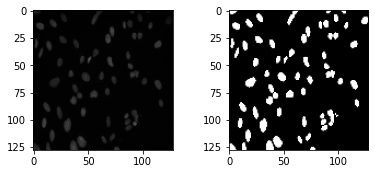

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    c = c * tf.keras.activations.tanh(tf.keras.activations.softplus(c))
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = c * tf.keras.activations.tanh(tf.keras.activations.softplus(c))
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(concat)
    c = c * tf.keras.activations.tanh(tf.keras.activations.softplus(c))
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = c * tf.keras.activations.tanh(tf.keras.activations.softplus(c))
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    c = c * tf.keras.activations.tanh(tf.keras.activations.softplus(c))
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = c * tf.keras.activations.tanh(tf.keras.activations.softplus(c))
    return c

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
   
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (2, 2), padding="same",  activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Softplus (TensorFlo [(None, 128, 128, 16 0           conv2d[0][0]                     
________________________________________________________________________________

In [10]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history_relu = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/35
39/39 [==============================] - 102s 3s/step - loss: 0.4853 - acc: 0.8435 - val_loss: 0.4510 - val_acc: 0.8176
Epoch 2/35
39/39 [==============================] - 35s 893ms/step - loss: 0.4068 - acc: 0.8448 - val_loss: 0.4714 - val_acc: 0.8173
Epoch 3/35
39/39 [==============================] - 32s 833ms/step - loss: 0.5297 - acc: 0.8342 - val_loss: 0.4672 - val_acc: 0.8173
Epoch 4/35
39/39 [==============================] - 33s 836ms/step - loss: 0.4598 - acc: 0.8253 - val_loss: 0.4328 - val_acc: 0.8173
Epoch 5/35
39/39 [==============================] - 32s 829ms/step - loss: 0.4030 - acc: 0.8384 - val_loss: 0.4165 - val_acc: 0.8168
Epoch 6/35
39/39 [==============================] - 33s 838ms/step - loss: 0.3633 - acc: 0.8458 - val_loss: 0.3534 - val_acc: 0.8385
Epoch 7/35
39/39 [==============================] - 32s 826ms/step - loss: 0.3046 - acc: 0.8657 - val_loss: 0.2778 - val_acc: 0.8568
Epoch 8/35
39/39 [==============================] - 32s 831ms/step - lo

KeyboardInterrupt: 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


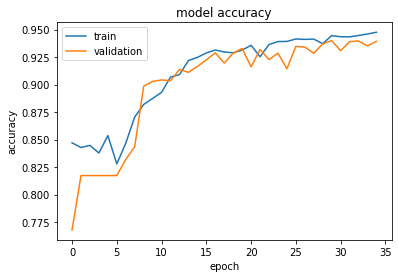

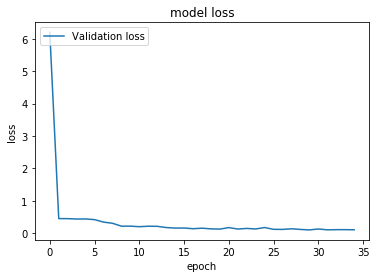

In [11]:
print(history_relu.history.keys())
#  "Accuracy"
plt.plot(history_relu.history['acc'])
plt.plot(history_relu.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
#plt.plot(history_relu.history['loss'])
plt.plot(history_relu.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Validation loss', 'validation'], loc='upper left')
plt.show()

In [12]:
## Save the Weights
model.save_weights("UNetW.hmish")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

0.8885157824042982
0.9409672830725462
0.11148421759570182


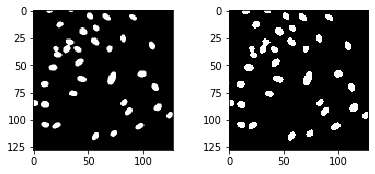

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)

ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")
y_pred=np.reshape(result[1]*255, (image_size, image_size))
y_true=np.reshape(y[1]*255, (image_size, image_size))
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
mean, std_1 = cv2.meanStdDev(y_pred, y_true)
print(iou_score) 
img1 = np.asarray(y_true).astype(np.bool)
img2 = np.asarray(y_pred).astype(np.bool)
if img1.sum() + img2.sum() == 0:
    print(1) 
intersection = np.logical_and(img1, img2)
print(2. * intersection.sum() / (img1.sum() + img2.sum()))
intersection=abs(intersection)
union=abs(union)
voe=1-(intersection.sum()/union.sum())
print(voe)

0.7628243814121907
0.8654570352618967
0.23717561858780933


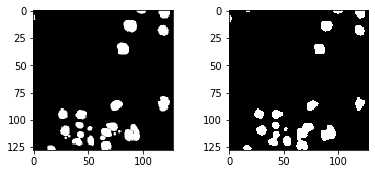

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

y_pred=np.reshape(result[0]*255, (image_size, image_size))
y_true=np.reshape(y[0]*255, (image_size, image_size))
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
mean, std_1 = cv2.meanStdDev(y_pred, y_true)
print(iou_score) 
img1 = np.asarray(y_true).astype(np.bool)
img2 = np.asarray(y_pred).astype(np.bool)
if img1.sum() + img2.sum() == 0:
    print(1) 
intersection = np.logical_and(img1, img2)
print(2. * intersection.sum() / (img1.sum() + img2.sum()))
intersection=abs(intersection)
union=abs(union)
voe=1-(intersection.sum()/union.sum())
print(voe)